##Importing Modules

In [ ]:

# Import matplotlib library
import matplotlib.pyplot as plt
 
# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
 
import numpy as np
import time

Now we import the LFW_people dataset using sklearn’s fetch_lfw_people function API. LFW_prople is the preprocess excerpt of LFW. It contains 13233 images of 5749 classes of shape 125 * 94. 

This function provides an parameter min_faces_per_person. This parameter allows us to select the classes that have at least min_faces_per_person different pictures. This function also has a parameter resize which resize every image in the extracted face. We use min_faces_per_person = 70 and resize = 0.4. 

In [ ]:

# this command will download the LFW_people's dataset to hard disk.
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
 
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
 
# Instead of providing 2D data, X has data already in the form  of a vector that
# is required in this approach.
X = lfw_people.data
n_features = X.shape[1]
 
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
 
# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  1850
Number of Class Labels:  7


##Data Exploration

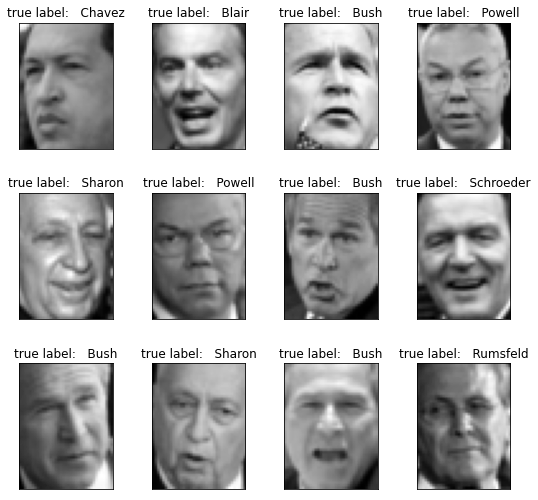

In [ ]:

# Function to plot images in 3 * 4 
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())
 
# Generate true labels above the images
def true_title(Y, target_names, i):
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
    return 'true label:   % s' % (true_name)
 
true_titles = [true_title(y, target_names, i)
                     for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)

Now, we apply train_test_split to split the data into training and testing sets. We use 25% of the data for testing. 

## data Splitting

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)
print("size of training Data is % d and Testing Data is % d" %(
        y_train.shape[0], y_test.shape[0]))

size of training Data is  966 and Testing Data is  322


##Implementing PCA

Now, we apply the PCA algorithm on the training dataset which computes EigenFaces. Here, we take n_components = 150 means we extract the top 150 Eigenfaces from the algorithm. We also print the time taken to apply this algorithm. 

In [ ]:
from time import time
n_components = 150
 
t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
          whiten = True).fit(X_train)
print("done in % 0.3fs" % (time() - t0))
 
eigenfaces = pca.components_.reshape((n_components, h, w))
 
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in % 0.3fs" % (time() - t0))

done in  0.489s
Projecting the input data on the eigenfaces orthonormal basis
done in  0.049s


The above code generates the EigenFace and each image is represented by a vector of size 1 * 150. The values in this vector represent the coefficient corresponding to that Eigenface. These coefficient are generated using transform function on the function.



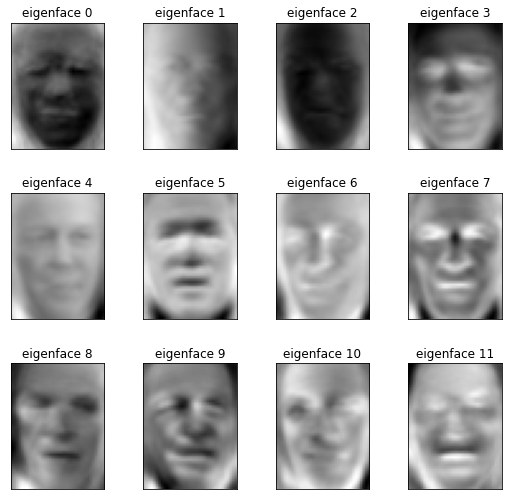

In [ ]:
#Plotting most siginificant eigen faces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

##Explore the cofficient generated by above algorithm

In [ ]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimensions of training set = % s and Test Set = % s"%(
        X_train.shape, X_test.shape))

Sample Data point after applying PCA
 [-2.075601   -1.0457928   2.1269362   0.0368191  -0.75756687 -0.51737016
  0.85550624  1.0519342   0.45774376  0.01347652 -0.03962649  0.6387264
  0.48167878  2.3378508   1.778443    0.13310231 -2.2713077  -4.4569874
  2.097614   -1.1379236   0.18843715 -0.33498368  1.1254561  -0.3240378
  0.1409417   1.0769484   0.75881416 -0.09978469  3.119968    0.88375616
 -0.89338964  1.1595869   1.4306449   1.6856548   1.3434688  -1.2590969
 -0.63914126 -2.3362846  -0.0137503  -1.463914   -0.46888462 -1.0548304
 -1.3328384   1.1364343   2.2223756  -1.8016515  -0.30630115 -1.0283825
  4.7734337   3.460054    1.9258875  -1.3515948  -0.25905332  2.010444
 -1.0562125   0.36077625  1.1703486   0.7572535   0.9002748   0.59925157
 -0.4658273   2.097456    1.34524     1.9326084   5.066187   -0.7055203
  0.6060598  -0.8995794  -0.2146291  -2.109608   -1.6801574  -0.19573423
 -1.7432904  -3.0569975   2.050363    0.3926334   0.12702928  1.2061172
 -0.7955528  -1.3889787

##Using SVM for classification

Now we use Support Vector Machine (SVM) as our classification algorithm. We train the data using the PCA coefficient generated in previous steps. 

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in % 0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
 
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in % 0.3fs" % (time() - t0))
# print classification results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Fitting the classifier to the training set
done in  24.820s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in  0.062s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.84      0.87      0.85        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.86       322
        macro avg       0.89      0.73      0.79       322
     weighted avg       0.87      0.86      0.85       322

Confusion Matrix is:
[[  7   1   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  1   1  18   7   0   0   0]
 [  0   3   0 143   0   0  

Predicting people's names on the test set
done in 0.056s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.84      0.87      0.85        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.86       322
        macro avg       0.89      0.73      0.79       322
     weighted avg       0.87      0.86      0.85       322



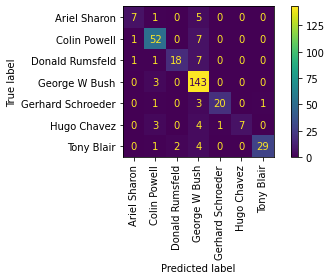

In [ ]:
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Now we plot our predictions over here:

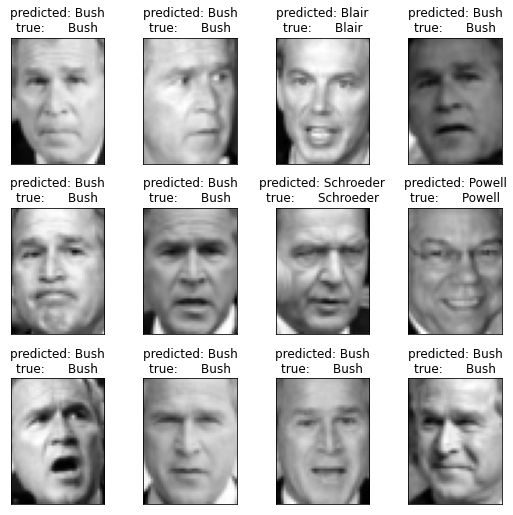

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)